# Inspiration
- https://medium.com/@xjurajkmec/pairwise-learning-for-neural-link-prediction-f1d16a0d28f6#:~:text=The%20idea%20of%20using%20graph,edges%20in%20the%20given%20graph

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch import torch
from sklearn import preprocessing

from torch_geometric.data import Data
from torch_geometric.transforms.to_undirected import ToUndirected

In [5]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

In [6]:
post_article = postings.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ArticlePublishingDate": "min"})
post_article = post_article.reset_index()
votes_trunc = votes[['ID_CommunityIdentity', 'ID_Posting']]
postings_trunc = postings.groupby(by = ['ID_Posting', 'ID_Article']).agg({"ArticlePublishingDate": "min"}).reset_index().drop(columns = ['ArticlePublishingDate'])
vote_user_article = votes_trunc.merge(postings_trunc, left_on = ['ID_Posting'], right_on = ['ID_Posting'])
vote_article = vote_user_article.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ID_Posting": "count"}).reset_index().drop(columns = ['ID_Posting'])
user_article_interaction = pd.concat([post_article, vote_article]).drop(columns=['ArticlePublishingDate'])

### Subsetting edges

In [7]:
# random sampling
# user_article_interaction = user_article_interaction.sample(n=int(user_article_interaction.shape[0]/20), random_state=1)

# sequential sampling
user_article_interaction = user_article_interaction.iloc[:int(user_article_interaction.shape[0]/4), :]

In [8]:
user_article_interaction.shape

(272983, 2)

In [9]:
# create edge names
user_article_interaction["user_id"] = "u-" + user_article_interaction["ID_CommunityIdentity"].astype(str)
user_article_interaction["article_id"] = "a-" + user_article_interaction["ID_Article"].astype(str)

# concatenate nodes and create node encodings
nodes = np.concatenate((np.unique(user_article_interaction['user_id']), np.unique(user_article_interaction['article_id'])))
nodes_user = np.unique(user_article_interaction['user_id'])
nodes_article = np.unique(user_article_interaction['article_id'])

label_encoder_nodes = preprocessing.LabelEncoder()
label_encoder_nodes.fit(nodes)
nodes_enc = label_encoder_nodes.transform(nodes)

user_article_interaction["user_id_enc"] = label_encoder_nodes.transform(user_article_interaction["user_id"])
user_article_interaction["article_enc"] = label_encoder_nodes.transform(user_article_interaction["article_id"])

### Graph construction

In [10]:

# generate edge list
edge_list = []
for row in user_article_interaction.itertuples():
    edge_list.append([row.user_id_enc, row.article_enc])

# create tensor with nodes
x = torch.tensor(nodes_enc, dtype=torch.long)

# create tensor with edges
edge_index = torch.tensor(edge_list, dtype=torch.long)

# initialize graph with nodes and edges
graph = Data(x=x, edge_index=edge_index.t())

# validate graph
graph.validate(raise_on_error=True)

# add reverse edges to the graph
graph = ToUndirected()(graph)


True

### Modelling with graphSAGE GNN

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator 
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import matplotlib.pyplot as plt 
import numpy as np 

import subprocess as sp
import os
from tqdm import tqdm


In [16]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()

        # GraphSAGE convolutional layers
        conv_model = pyg.nn.SAGEConv

        self.convs = nn.ModuleList()

        # add the first convolutional layer
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing processing 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return final layer of embeddings if specified
        if self.emb:
            return x

        # Else return class probabilities
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [17]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [18]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [19]:
def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer, debug=False):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param pos_train_edge: (PE, 2) Positive edges used for training supervision loss
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    model.train()
    link_predictor.train()
    train_losses = []
    
    pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
    dataloader = DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True)

    for edge_id in dataloader:
        
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id]  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )
        
        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
                                    num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        
        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        if debug:
            print("Train edges batch shape: ", edge_id.shape)
            print("Train node embedding shape: ", node_emb.shape)
            print("Train positive edge shape: ", pos_edge.shape)
            print("Shape of positive edges (source): ", pos_edge.T[0].shape)
            print("Shape of positive edges (target): ", pos_edge.T[1].shape)
            print("Node embedding shape: ", node_emb[pos_edge[0]].shape)
            print("Train positive prediction shape: ", pos_pred.shape)
            print("Train negative prediction shape: ", neg_pred.shape)
    if debug:
        print("Train losses: ", train_losses)
        print("Train losses length: ", i)

    print("Train loss: ", sum(train_losses) / len(train_losses))

    return sum(train_losses) / len(train_losses)

In [20]:
get_gpu_memory()

[1642]

In [21]:
# from utils import do_edge_split
# split_edge = do_edge_split(graph, fast_split = False)

In [22]:
def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
    """
    Evaluates graph model on validation and test edges
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param split_edge: Dictionary of (e, 2) edges for val pos/neg and test pos/neg edges
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param evaluator: OGB evaluator to calculate hits @ k metric
    :return: hits @ k results
    """
    model.eval()
    predictor.eval()

    node_emb = model(emb, edge_index)

    pos_valid_edge = split_edge['valid']['edge'].T.to(emb.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].T.to(emb.device)
    pos_test_edge = split_edge['test']['edge'].T.to(emb.device)
    neg_test_edge = split_edge['test']['edge_neg'].T.to(emb.device)

    with torch.no_grad():

        loss_val_pos = []
        pos_valid_preds = []
        for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
            edge = pos_valid_edge[perm].t()
            pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            loss_val_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
        loss_val_pos_val = sum(loss_val_pos) / len(loss_val_pos)

        loss_val_neg = []
        neg_valid_preds = []
        for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
            edge = neg_valid_edge[perm].t()
            neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            loss_val_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
        loss_val_neg_val = sum(loss_val_neg) / len(loss_val_neg)

        loss_test_pos = []
        pos_test_preds = []
        for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
            edge = pos_test_edge[perm].t()
            pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            loss_test_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        pos_test_pred = torch.cat(pos_test_preds, dim=0)
        loss_test_pos_val = sum(loss_test_pos) / len(loss_test_pos)

        loss_test_neg = []
        neg_test_preds = []
        for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
            edge = neg_test_edge[perm].t()
            neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
            loss_test_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        neg_test_pred = torch.cat(neg_test_preds, dim=0)
        loss_test_neg_val = sum(loss_test_neg) / len(loss_test_neg)

        results = {}
        results["loss_val_pos"] = loss_val_pos_val
        results["loss_val_neg"] = loss_val_neg_val
        results["loss_test_pos"] = loss_test_pos_val
        results["loss_test_neg"] = loss_test_neg_val

        print("Loss val pos: ", loss_val_pos_val)
        print("Loss val neg: ", loss_val_neg_val)
        print("Loss test pos: ", loss_test_pos_val)
        print("Loss test neg: ", loss_test_neg_val)

    return results

In [23]:
# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = "cpu"
optim_wd = 0
epochs = 20
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 5e-5
node_emb_dim = 256
batch_size = 512

In [24]:
from utils import create_train_test_split_rls

# create train, test, validation splits with negative sampling and stores them in split_edge dictionary
split_edge = create_train_test_split_rls(graph)

Train edges:  torch.Size([2, 218387])
Valid positive edges:  torch.Size([2, 27298])
Valid negative edges:  torch.Size([2, 27298])
Test positive edges:  torch.Size([2, 27298])
Test negative edges:  torch.Size([2, 27298])


In [25]:
evaluator = Evaluator(name='ogbl-ddi')
print(evaluator.expected_input_format)

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


In [26]:
split_edge['train']['edge']

tensor([[  593,  1488,  2400,  ...,  1680,   989,  1890],
        [18580, 11422, 10614,  ..., 14865, 14355, 10035]])

In [27]:
split_edge['valid']['edge']

tensor([[ 2051,  3715,  3451,  ...,  4116,   721,  4055],
        [12828, 12303,  8492,  ..., 13299, 13113, 13571]])

In [28]:
split_edge['test']['edge']

tensor([[  457,    16,  2337,  ...,   867,  2925,  3205],
        [15310, 12491, 10892,  ..., 19064,  6912, 12345]])

In [29]:
# https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN#scrollTo=gG6mGvs9Uqnt

pos_train_edge = split_edge['train']['edge'].to(device)

emb = torch.nn.Embedding(graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

evaluator = Evaluator(name='ogbl-ddi')

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = graph.edge_index.to(device)

print("Before training. Available GPU memory: ", get_gpu_memory())

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    loss_val_pos_list.append(result["loss_val_pos"])
    loss_val_neg_list.append(result["loss_val_neg"])
    loss_test_pos_list.append(result["loss_test_pos"])
    loss_test_neg_list.append(result["loss_test_neg"])

Before training. Available GPU memory:  [1618]


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_158677/70710965.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T


Train loss:  1.3263686440309261


  5%|▌         | 1/20 [01:26<27:32, 86.99s/it]

Loss val pos:  tensor(0.6253)
Loss val neg:  tensor(0.6005)
Loss test pos:  tensor(0.6249)
Loss test neg:  tensor(0.5999)


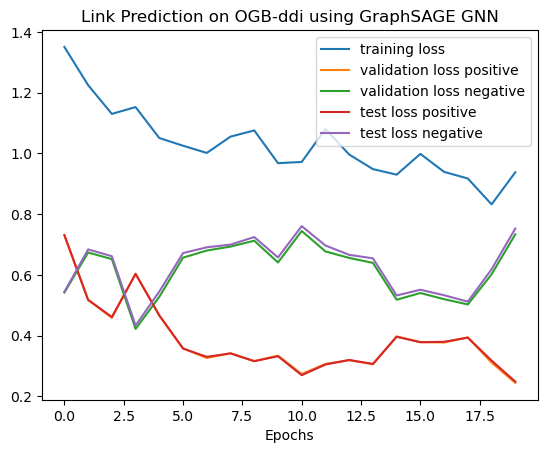

In [ ]:
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(loss_val_pos_list,label="validation loss positive")
plt.plot(loss_val_neg_list,label="validation loss negative")
plt.plot(loss_test_pos_list,label="test loss positive")
plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()